# Práctica 1: Aprendizaje Supervisado
## Dataset: Estimation of Obesity Levels Based on Eating Habits and Physical Condition

Refactor de la Práctica 0: mismo dataset, mismo pipeline de tratamiento de datos y foco en comparación de modelos supervisados.

## 0. Configuración e importaciones

In [1]:
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)

warnings.filterwarnings('ignore')
sns.set_palette('husl')

# Constantes fijadas por el plan
DATA_PATH = Path('..') / 'practica_0' / 'data' / 'ObesityDataSet_raw_and_data_sinthetic.csv'
RANDOM_STATE = 42
CV_FOLDS = 5

BASE_DIR = Path('.')
IMAGES_DIR = BASE_DIR / 'images'
TABLES_DIR = BASE_DIR / 'tables'
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

print(f'DATA_PATH: {DATA_PATH.resolve()}')
print(f'IMAGES_DIR: {IMAGES_DIR.resolve()}')
print(f'TABLES_DIR: {TABLES_DIR.resolve()}')

DATA_PATH: /Users/jordiblascolozano/Documents/IA/3erAnyo/2doCuatri/aprendizaje_avanzado/practicas/practica_0/data/ObesityDataSet_raw_and_data_sinthetic.csv
IMAGES_DIR: /Users/jordiblascolozano/Documents/IA/3erAnyo/2doCuatri/aprendizaje_avanzado/practicas/practica_1/images
TABLES_DIR: /Users/jordiblascolozano/Documents/IA/3erAnyo/2doCuatri/aprendizaje_avanzado/practicas/practica_1/tables


## 1. Dataset y preprocesado (idéntico a Práctica 0)

In [2]:
def save_table(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """Guarda tabla en CSV y LaTeX para reutilizar en la memoria."""
    csv_path = TABLES_DIR / f'{name}.csv'
    tex_path = TABLES_DIR / f'{name}.tex'

    df.to_csv(csv_path, index=False)

    latex_df = df.copy()
    for col in latex_df.columns:
        if pd.api.types.is_float_dtype(latex_df[col]):
            latex_df[col] = latex_df[col].map(lambda x: f'{x:.4f}')
    tex_path.write_text(latex_df.to_latex(index=False, escape=True), encoding='utf-8')

    return df


def weighted_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_w': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_w': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_w': f1_score(y_true, y_pred, average='weighted', zero_division=0),
    }


def evaluate_model(model, X_train, y_train, X_test, y_test, cv=CV_FOLDS, scoring='accuracy'):
    mdl_cv = clone(model)
    cv_scores = cross_val_score(mdl_cv, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    mdl = clone(model)
    t0 = time.perf_counter()
    mdl.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0

    y_pred = mdl.predict(X_test)
    m = weighted_metrics(y_test, y_pred)

    result = {
        'cv_accuracy_mean': float(cv_scores.mean()),
        'cv_accuracy_std': float(cv_scores.std()),
        'test_accuracy': float(m['accuracy']),
        'precision_w': float(m['precision_w']),
        'recall_w': float(m['recall_w']),
        'f1_w': float(m['f1_w']),
        'fit_time_s': float(fit_time),
    }
    return result, mdl, y_pred


def save_confusion(y_true, y_pred, class_names, filename, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(9, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(title)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()


def preprocess_like_p0(data_path=DATA_PATH):
    df = pd.read_csv(data_path)
    raw_rows = len(df)

    # Columnas
    target_col = 'NObeyesdad'
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Fase 1: outliers Weight/Height por IQR
    mask_clean = pd.Series(True, index=df.index)
    for col in ['Weight', 'Height']:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lb = q1 - 1.5 * iqr
        ub = q3 + 1.5 * iqr
        mask_clean &= (df[col] >= lb) & (df[col] <= ub)

    df = df[mask_clean].reset_index(drop=True)
    rows_after_wh = len(df)

    # Fase 2: Box-Cox en Age + IQR sobre Age transformada
    df['Age'], lambda_age = stats.boxcox(df['Age'] + 1)

    q1 = df['Age'].quantile(0.25)
    q3 = df['Age'].quantile(0.75)
    iqr = q3 - q1
    lb = q1 - 1.5 * iqr
    ub = q3 + 1.5 * iqr
    df = df[(df['Age'] >= lb) & (df['Age'] <= ub)].reset_index(drop=True)
    rows_after_age = len(df)

    # Separar X / y
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encoding target
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

    # Encoding features (idéntico P0)
    X_processed = X.copy()
    binary_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
    for col in binary_cols:
        if col in X_processed.columns:
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col])

    multi_cat_cols = ['CAEC', 'CALC', 'MTRANS']
    X_processed = pd.get_dummies(X_processed, columns=multi_cat_cols, drop_first=True)

    # Split 80/20 estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed,
        y_encoded,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y_encoded,
    )

    # Fase 3 (post-split): filtro Z-score en train sobre numéricas
    scaler_temp = StandardScaler()
    X_train_z = scaler_temp.fit_transform(X_train[numeric_cols])
    mask_inliers = (np.abs(X_train_z) <= 3).all(axis=1)

    rows_train_before = len(X_train)
    X_train = X_train[mask_inliers].reset_index(drop=True)
    y_train = y_train[mask_inliers]
    rows_train_after = len(X_train)

    checks = {
        'raw_rows': raw_rows,
        'rows_after_weight_height': rows_after_wh,
        'rows_after_age': rows_after_age,
        'lambda_age_boxcox': float(lambda_age),
        'split_train': rows_train_before,
        'split_test': len(X_test),
        'rows_removed_train_zscore': int(rows_train_before - rows_train_after),
    }

    return {
        'df': df,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'target_col': target_col,
        'numeric_cols': numeric_cols,
        'feature_names': X_processed.columns.tolist(),
        'label_encoder_target': le_target,
        'checks': checks,
    }

In [3]:
data = preprocess_like_p0(DATA_PATH)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

df = data['df']
numeric_cols = data['numeric_cols']
feature_names = data['feature_names']
le_target = data['label_encoder_target']
class_names = le_target.classes_

checks_df = pd.DataFrame([data['checks']])
save_table(checks_df, '00_preprocessing_checks')
checks_df

,raw_rows,rows_after_weight_height,rows_after_age,lambda_age_boxcox,split_train,split_test,rows_removed_train_zscore
0,2111,2109,2107,-1.641515,1685,422,0


### Check de paridad con Práctica 0
Esperado: `2111 -> 2109 -> 2107`, `lambda ≈ -1.6415`, `split 1685/422`, `Z-score train elimina 0`.

In [4]:
expected = {
    'raw_rows': 2111,
    'rows_after_weight_height': 2109,
    'rows_after_age': 2107,
    'split_train': 1685,
    'split_test': 422,
    'rows_removed_train_zscore': 0,
}

for k, v in expected.items():
    print(f'{k}: {data["checks"][k]} (esperado {v})')
print(f"lambda_age_boxcox: {data['checks']['lambda_age_boxcox']:.6f} (esperado ≈ -1.6415)")

raw_rows: 2111 (esperado 2111)
rows_after_weight_height: 2109 (esperado 2109)
rows_after_age: 2107 (esperado 2107)
split_train: 1685 (esperado 1685)
split_test: 422 (esperado 422)
rows_removed_train_zscore: 0 (esperado 0)
lambda_age_boxcox: -1.641515 (esperado ≈ -1.6415)


## 2. EDA heredado de P0 (resumen visual)
Mismo EDA y mismas figuras clave; explicación mínima.

In [5]:
# Estadística descriptiva breve
stats_df = df[numeric_cols].describe().round(4).T.reset_index().rename(columns={'index': 'feature'})
save_table(stats_df, '01_eda_descriptive_stats')
stats_df.head()

,feature,count,mean,std,min,25%,50%,75%,max
0,Age,2107.0,0.6058,0.0011,0.6034,0.6051,0.6058,0.6065,0.6085
1,Height,2107.0,1.7015,0.0931,1.4500,1.6300,1.7002,1.7683,1.9757
2,Weight,2107.0,86.5340,26.1329,39.0000,65.3939,83.0000,107.2988,165.0573
3,FCVC,2107.0,2.4184,0.5339,1.0000,2.0000,2.3827,3.0000,3.0000
4,NCP,2107.0,2.6850,0.7787,1.0000,2.6586,3.0000,3.0000,4.0000


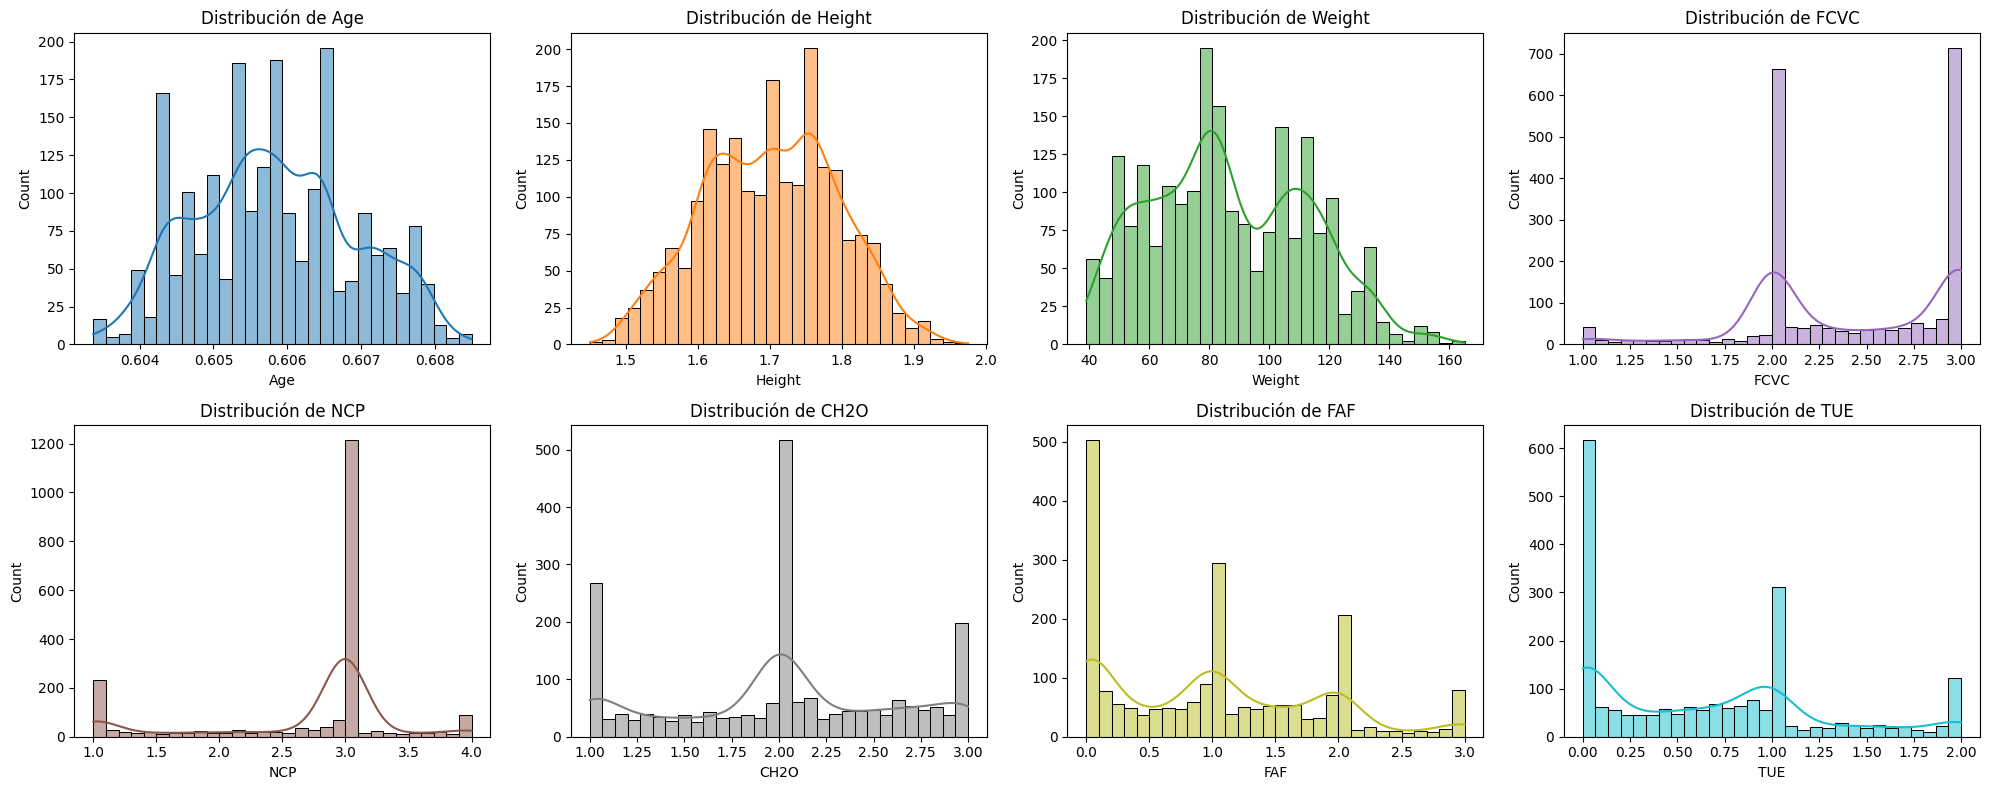

In [6]:
# Distribuciones
n_numeric = len(numeric_cols)
n_cols = 4
n_rows = (n_numeric + n_cols - 1) // n_cols
colors = plt.cm.tab10(np.linspace(0, 1, n_numeric))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, kde=True, bins=30, ax=axes[idx], color=colors[idx])
    axes[idx].set_title(f'Distribución de {col}')

for idx in range(n_numeric, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(IMAGES_DIR / 'distribuciones_univariadas.png', dpi=300, bbox_inches='tight')
plt.show()

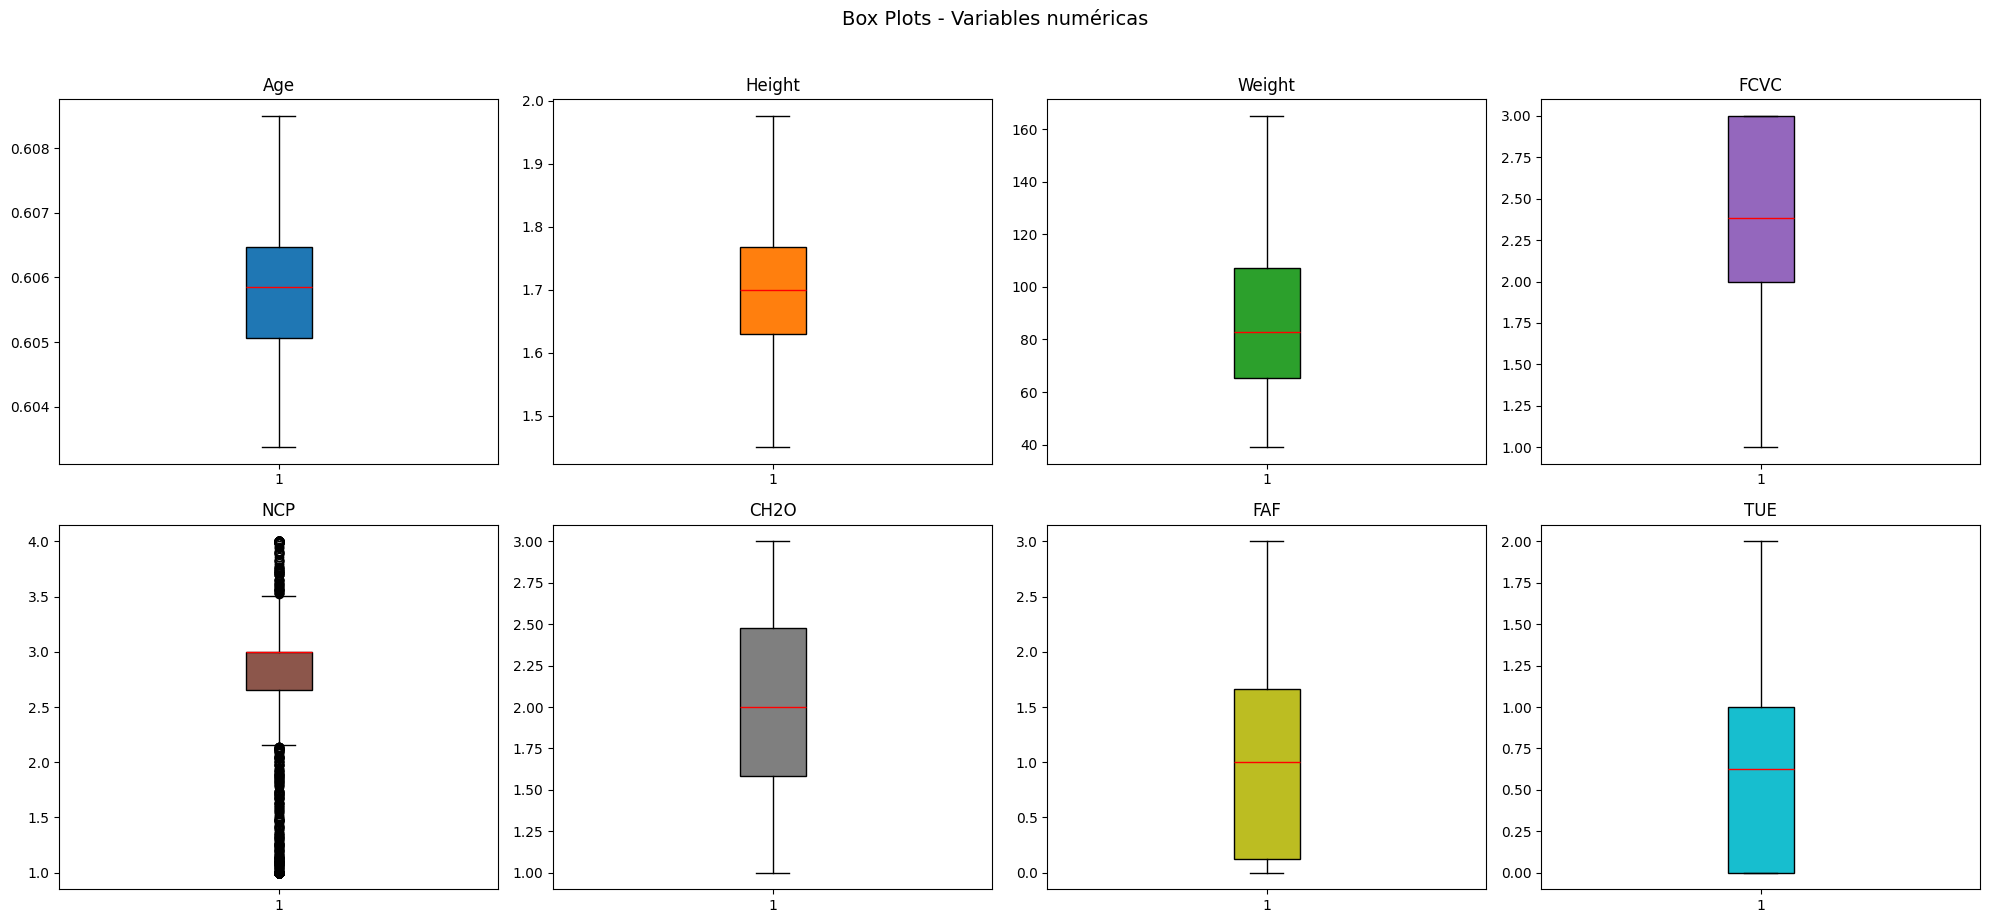

In [7]:
# Boxplots
fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes = axes.flatten()
for idx, col in enumerate(numeric_cols):
    bp = axes[idx].boxplot(df[col].dropna(), patch_artist=True)
    bp['boxes'][0].set_facecolor(colors[idx])
    bp['medians'][0].set_color('red')
    axes[idx].set_title(col)

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Box Plots - Variables numéricas', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(IMAGES_DIR / 'boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

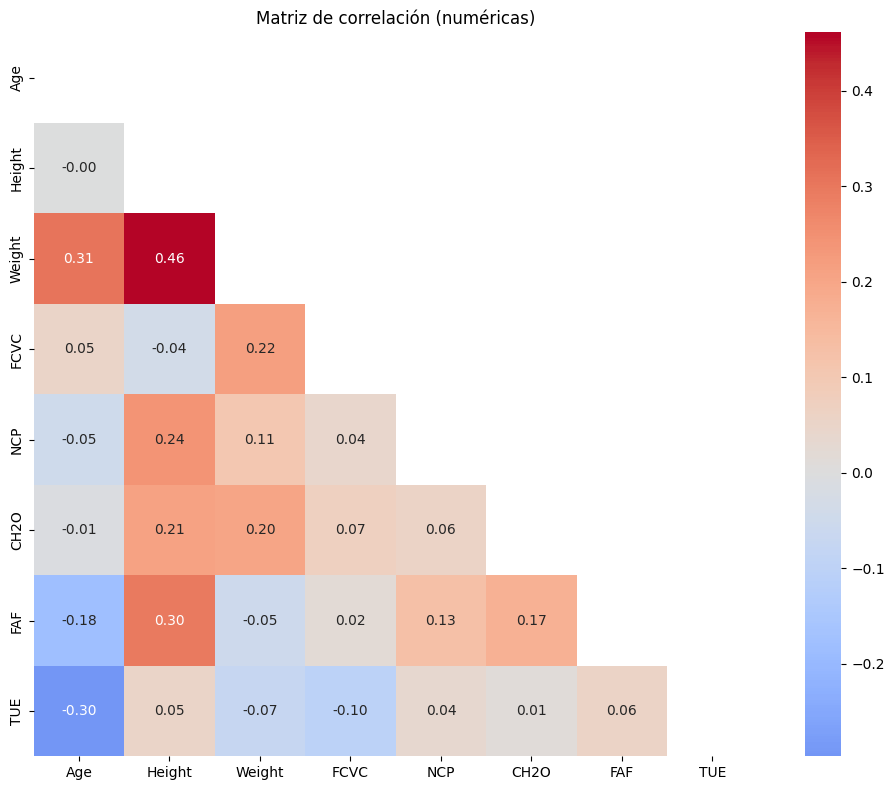

,feature,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,Age,1.000000,-0.001726,0.305819,0.052303,-0.045648,-0.008924,-0.179619,-0.297034
1,Height,-0.001726,1.000000,0.461078,-0.037854,0.243601,0.211622,0.295740,0.051411
2,Weight,0.305819,0.461078,1.000000,0.216164,0.107022,0.200893,-0.053191,-0.072994
3,FCVC,0.052303,-0.037854,0.216164,1.000000,0.041788,0.069282,0.017577,-0.102888
4,NCP,-0.045648,0.243601,0.107022,0.041788,1.000000,0.056901,0.128882,0.035634
5,CH2O,-0.008924,0.211622,0.200893,0.069282,0.056901,1.000000,0.168828,0.012865
6,FAF,-0.179619,0.295740,-0.053191,0.017577,0.128882,0.168828,1.000000,0.055683
7,TUE,-0.297034,0.051411,-0.072994,-0.102888,0.035634,0.012865,0.055683,1.000000


In [8]:
# Correlación
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, mask=mask)
plt.title('Matriz de correlación (numéricas)')
plt.tight_layout()
plt.savefig(IMAGES_DIR / 'correlacion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

corr_long = corr_matrix.reset_index().rename(columns={'index': 'feature'})
save_table(corr_long, '02_eda_correlation_matrix')


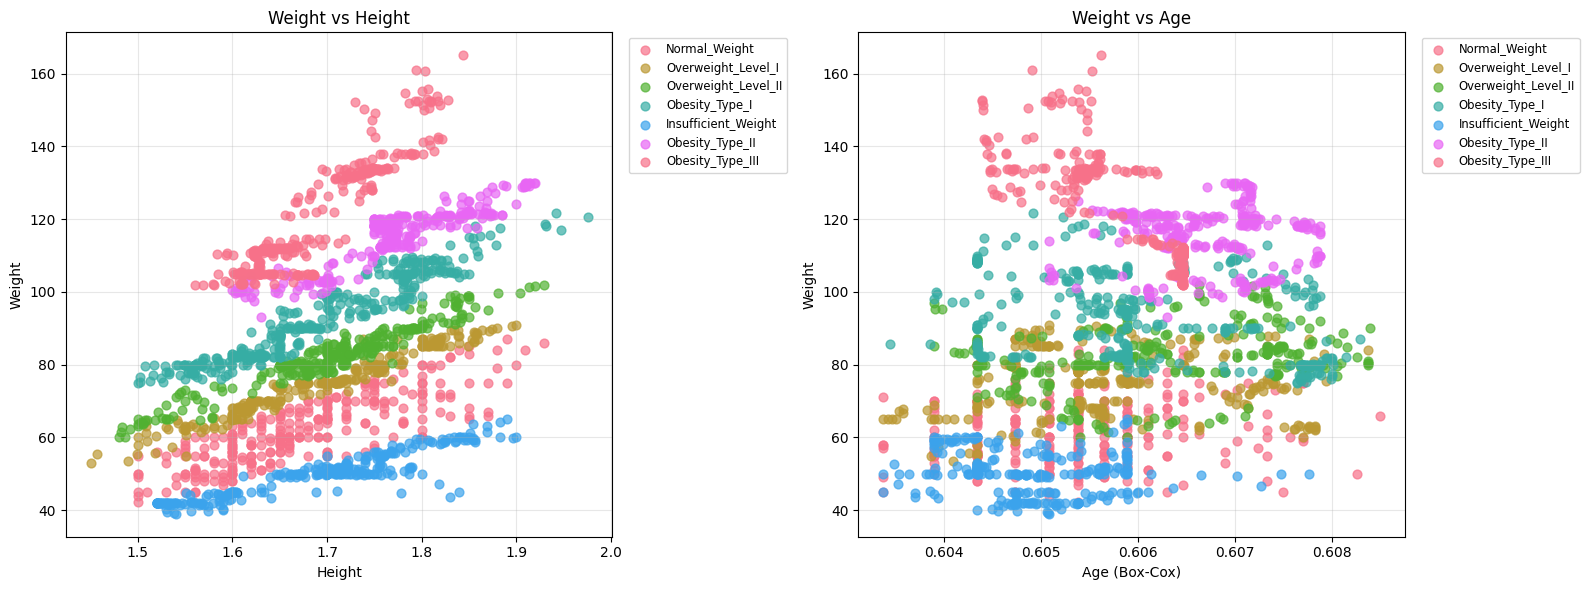

In [9]:
# Scatter por clase (Weight/Height y Weight/Age)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for label in df['NObeyesdad'].unique():
    mask = df['NObeyesdad'] == label
    axes[0].scatter(df.loc[mask, 'Height'], df.loc[mask, 'Weight'], label=label, alpha=0.7, s=40)

axes[0].set_xlabel('Height')
axes[0].set_ylabel('Weight')
axes[0].set_title('Weight vs Height')
axes[0].grid(alpha=0.3)
axes[0].legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')

for label in df['NObeyesdad'].unique():
    mask = df['NObeyesdad'] == label
    axes[1].scatter(df.loc[mask, 'Age'], df.loc[mask, 'Weight'], label=label, alpha=0.7, s=40)

axes[1].set_xlabel('Age (Box-Cox)')
axes[1].set_ylabel('Weight')
axes[1].set_title('Weight vs Age')
axes[1].grid(alpha=0.3)
axes[1].legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig(IMAGES_DIR / 'scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

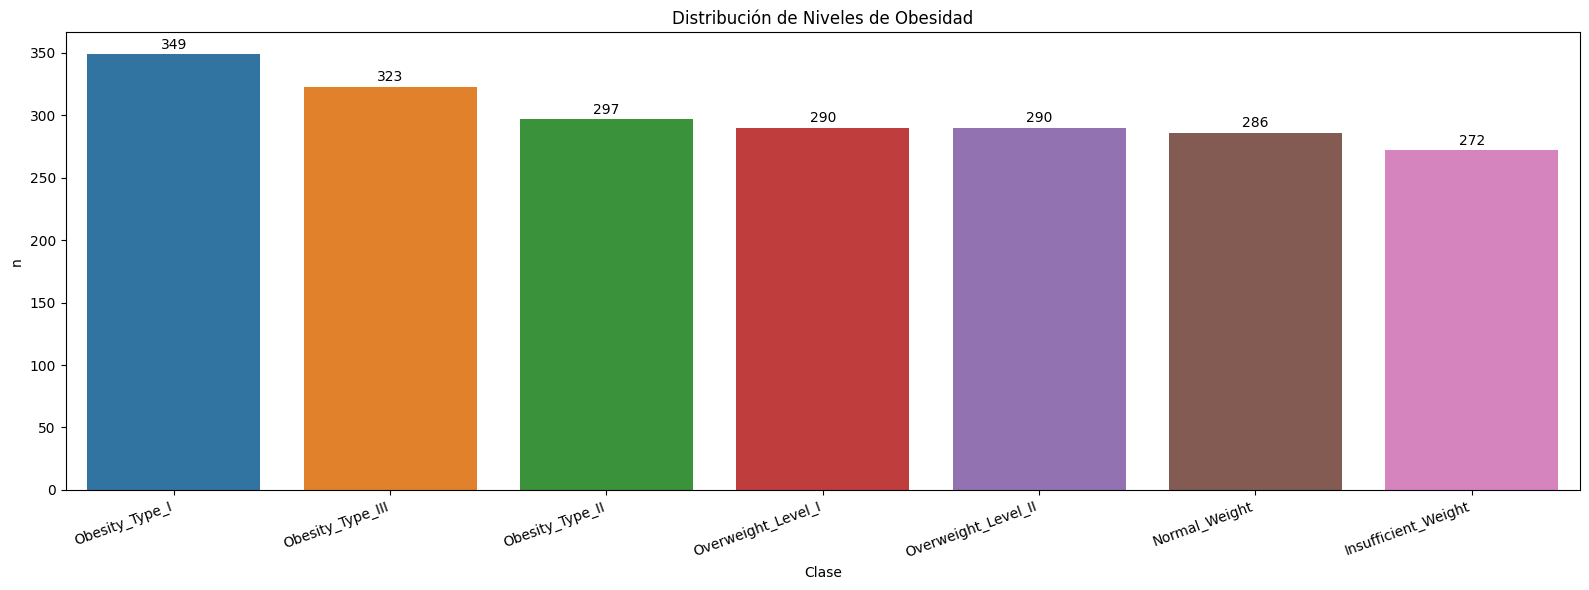

,class,count
0,Obesity_Type_I,349
1,Obesity_Type_III,323
2,Obesity_Type_II,297
3,Overweight_Level_I,290
4,Overweight_Level_II,290
5,Normal_Weight,286
6,Insufficient_Weight,272


In [10]:
# Distribución de clases
class_counts = df['NObeyesdad'].value_counts()

plt.figure(figsize=(16, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='tab10')
ax.set_title('Distribución de Niveles de Obesidad')
ax.set_xlabel('Clase')
ax.set_ylabel('n')
plt.xticks(rotation=20, ha='right')

for i, v in enumerate(class_counts.values):
    ax.text(i, v + 2, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(IMAGES_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

class_dist_df = class_counts.reset_index()
class_dist_df.columns = ['class', 'count']
save_table(class_dist_df, '03_eda_class_distribution')
class_dist_df

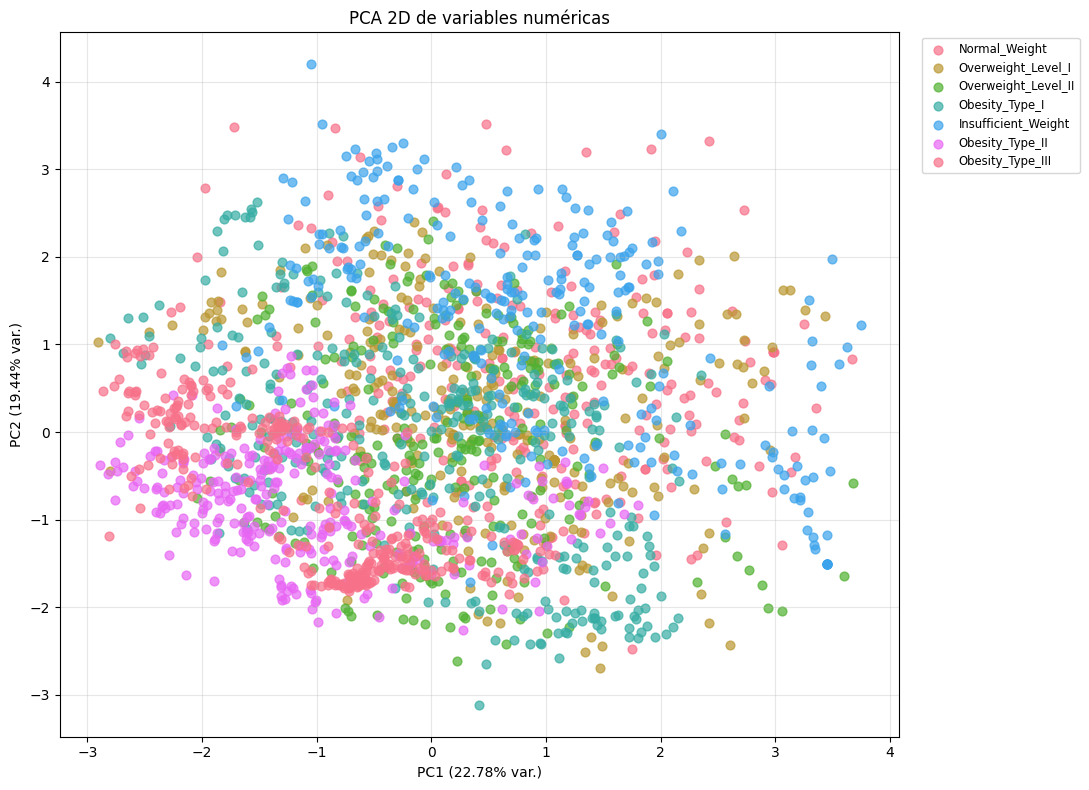

,component,explained_variance_ratio
0,PC1,0.227785
1,PC2,0.194434


In [11]:
# PCA 2D
X_numeric = df[numeric_cols].copy()
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X_numeric)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_pca)

plt.figure(figsize=(11, 8))
for label in df['NObeyesdad'].unique():
    mask = df['NObeyesdad'] == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, s=40, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var.)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var.)')
plt.title('PCA 2D de variables numéricas')
plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(IMAGES_DIR / 'pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

pca_info = pd.DataFrame({
    'component': ['PC1', 'PC2'],
    'explained_variance_ratio': pca.explained_variance_ratio_
})
save_table(pca_info, '04_eda_pca_variance')
pca_info

## 3. Parte 1: Support Vector Machines

In [12]:
# 1.1 SVM con kernels por defecto
svm_kernels = {
    'Linear': SVC(kernel='linear', random_state=RANDOM_STATE),
    'Poly (d=3)': SVC(kernel='poly', degree=3, random_state=RANDOM_STATE),
    'RBF': SVC(kernel='rbf', random_state=RANDOM_STATE),
    'Sigmoid': SVC(kernel='sigmoid', random_state=RANDOM_STATE),
}

rows = []
svm_kernel_models = {}
for name, svc in svm_kernels.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', svc),
    ])
    result, fitted, y_pred = evaluate_model(pipe, X_train, y_train, X_test, y_test)
    n_sv = int(fitted.named_steps['svm'].n_support_.sum())
    pct_training = 100 * n_sv / len(X_train)
    rows.append({
        'kernel': name,
        'cv_accuracy_mean': result['cv_accuracy_mean'],
        'cv_accuracy_std': result['cv_accuracy_std'],
        'test_accuracy': result['test_accuracy'],
        'precision_w': result['precision_w'],
        'recall_w': result['recall_w'],
        'f1_w': result['f1_w'],
        'n_sv': n_sv,
        'pct_training_sv': pct_training,
        'fit_time_s': result['fit_time_s'],
    })
    svm_kernel_models[name] = (fitted, y_pred, result)

svm_kernels_df = pd.DataFrame(rows).sort_values('test_accuracy', ascending=False).reset_index(drop=True)
save_table(svm_kernels_df, '10_svm_kernels_default')
svm_kernels_df

,kernel,cv_accuracy_mean,cv_accuracy_std,test_accuracy,precision_w,recall_w,f1_w,n_sv,pct_training_sv,fit_time_s
0,Linear,0.941840,0.024940,0.938389,0.939125,0.938389,0.938064,565,33.531157,0.103165
1,RBF,0.852819,0.023183,0.872038,0.880678,0.872038,0.874658,1089,64.629080,0.112172
2,Poly (d=3),0.745401,0.020507,0.744076,0.761190,0.744076,0.738924,1202,71.335312,0.123924
3,Sigmoid,0.640950,0.032014,0.651659,0.649538,0.651659,0.650088,1217,72.225519,0.084468


In [13]:
# 1.2 Grid RBF
pipe_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=RANDOM_STATE)),
])

param_grid_rbf = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
}

grid_rbf = GridSearchCV(
    pipe_rbf,
    param_grid_rbf,
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=-1,
)
grid_rbf.fit(X_train, y_train)

print('Best params RBF:', grid_rbf.best_params_)
print('Best CV:', round(grid_rbf.best_score_, 4))
print('Best test:', round(grid_rbf.best_estimator_.score(X_test, y_test), 4))

rbf_rows = []
for params, cv_acc, fit_t in zip(
    grid_rbf.cv_results_['params'],
    grid_rbf.cv_results_['mean_test_score'],
    grid_rbf.cv_results_['mean_fit_time'],
):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=params['svm__C'], gamma=params['svm__gamma'], random_state=RANDOM_STATE)),
    ])
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0
    test_acc = pipe.score(X_test, y_test)
    n_sv = int(pipe.named_steps['svm'].n_support_.sum())

    rbf_rows.append({
        'C': params['svm__C'],
        'gamma': params['svm__gamma'],
        'cv_accuracy': cv_acc,
        'test_accuracy': test_acc,
        'n_sv': n_sv,
        'pct_training_sv': 100 * n_sv / len(X_train),
        'fit_time_s': fit_time,
        'cv_fit_time_s': fit_t,
    })

rbf_full_df = pd.DataFrame(rbf_rows).sort_values('cv_accuracy', ascending=False).reset_index(drop=True)

# Selección representativa (>=10)
mandatory_pairs = [(0.1, 0.001), (1, 'scale'), (10, 0.1), (100, 1)]
selected_idx = []
for c, g in mandatory_pairs:
    idx = rbf_full_df.index[(rbf_full_df['C'] == c) & (rbf_full_df['gamma'] == g)]
    if len(idx) > 0:
        selected_idx.append(int(idx[0]))

for i in rbf_full_df.index:
    if i not in selected_idx:
        selected_idx.append(int(i))
    if len(selected_idx) >= 10:
        break

rbf_rep_df = rbf_full_df.loc[sorted(set(selected_idx))].reset_index(drop=True)

save_table(rbf_full_df, '11_svm_rbf_grid_full')
save_table(rbf_rep_df, '12_svm_rbf_grid_representative')
rbf_rep_df

Best params RBF: {'svm__C': 100, 'svm__gamma': 0.01}
Best CV: 0.9401
Best test: 0.9431


,C,gamma,cv_accuracy,test_accuracy,n_sv,pct_training_sv,fit_time_s,cv_fit_time_s
0,100.0,0.01,0.940059,0.943128,629,37.329377,0.061153,0.083790
1,100.0,0.001,0.922255,0.940758,879,52.166172,0.071110,0.089364
2,100.0,auto,0.908605,0.921801,799,47.418398,0.085835,0.117413
3,100.0,scale,0.908605,0.921801,799,47.418398,0.080081,0.131481
4,10.0,scale,0.908012,0.909953,850,50.445104,0.084028,0.098530
5,10.0,auto,0.908012,0.909953,850,50.445104,0.079804,0.099110
6,10.0,0.1,0.889614,0.898104,943,55.964392,0.111821,0.138120
7,1.0,scale,0.852819,0.872038,1089,64.629080,0.094482,0.118607
8,100.0,1,0.785757,0.791469,1260,74.777448,0.235671,0.331457
9,0.1,0.001,0.165579,0.165877,1685,100.000000,0.290587,0.218193


In [14]:
# 1.3 Grid Polinomial
pipe_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', random_state=RANDOM_STATE)),
])

param_grid_poly = {
    'svm__degree': [2, 3, 4],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.1],
}

grid_poly = GridSearchCV(
    pipe_poly,
    param_grid_poly,
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=-1,
)
grid_poly.fit(X_train, y_train)

print('Best params Poly:', grid_poly.best_params_)
print('Best CV:', round(grid_poly.best_score_, 4))
print('Best test:', round(grid_poly.best_estimator_.score(X_test, y_test), 4))

poly_rows = []
for params, cv_acc in zip(grid_poly.cv_results_['params'], grid_poly.cv_results_['mean_test_score']):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            kernel='poly',
            degree=params['svm__degree'],
            C=params['svm__C'],
            gamma=params['svm__gamma'],
            random_state=RANDOM_STATE,
        )),
    ])
    pipe.fit(X_train, y_train)
    poly_rows.append({
        'degree': params['svm__degree'],
        'C': params['svm__C'],
        'gamma': params['svm__gamma'],
        'cv_accuracy': cv_acc,
        'test_accuracy': pipe.score(X_test, y_test),
        'n_sv': int(pipe.named_steps['svm'].n_support_.sum()),
    })

poly_full_df = pd.DataFrame(poly_rows).sort_values('cv_accuracy', ascending=False).reset_index(drop=True)
save_table(poly_full_df, '13_svm_poly_grid_full')
poly_full_df.head(12)

Best params Poly: {'svm__C': 10, 'svm__degree': 3, 'svm__gamma': 0.1}
Best CV: 0.8718
Best test: 0.8886


,degree,C,gamma,cv_accuracy,test_accuracy,n_sv
0,3,10.0,0.1,0.871810,0.888626,789
1,3,1.0,0.1,0.864095,0.876777,897
2,3,10.0,auto,0.860534,0.879147,916
3,3,10.0,scale,0.860534,0.879147,916
4,2,10.0,0.1,0.858754,0.845972,784
5,2,10.0,auto,0.847478,0.855450,900
6,2,10.0,scale,0.847478,0.855450,900
7,4,1.0,0.1,0.839169,0.843602,960
8,4,10.0,0.1,0.835608,0.845972,856
9,2,1.0,0.1,0.830861,0.838863,946


In [15]:
# 1.4 Comparación implementaciones lineales
linear_impl = {
    'SVC(linear)': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', random_state=RANDOM_STATE)),
    ]),
    'LinearSVC': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', LinearSVC(random_state=RANDOM_STATE, max_iter=10000)),
    ]),
    'SGDClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SGDClassifier(loss='hinge', random_state=RANDOM_STATE)),
    ]),
}

rows = []
for name, model in linear_impl.items():
    result, fitted, _ = evaluate_model(model, X_train, y_train, X_test, y_test)
    n_sv = np.nan
    if name == 'SVC(linear)':
        n_sv = int(fitted.named_steps['svm'].n_support_.sum())

    rows.append({
        'implementation': name,
        'cv_accuracy_mean': result['cv_accuracy_mean'],
        'cv_accuracy_std': result['cv_accuracy_std'],
        'test_accuracy': result['test_accuracy'],
        'n_sv': n_sv,
        'fit_time_s': result['fit_time_s'],
    })

svm_impl_df = pd.DataFrame(rows).sort_values('test_accuracy', ascending=False).reset_index(drop=True)
save_table(svm_impl_df, '14_svm_linear_implementations')
svm_impl_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,implementation,cv_accuracy_mean,cv_accuracy_std,test_accuracy,n_sv,fit_time_s
0,SVC(linear),0.941840,0.024940,0.938389,565.0,0.067786
1,LinearSVC,0.763205,0.034980,0.786730,NaN,4.267551
2,SGDClassifier,0.706231,0.031291,0.694313,NaN,0.043420


In [16]:
# 1.5 Análisis de vectores de soporte (configuraciones concretas)
sv_configs = {
    'Linear (C=1)': SVC(kernel='linear', C=1, random_state=RANDOM_STATE),
    'RBF (C=1, gamma=scale)': SVC(kernel='rbf', C=1, gamma='scale', random_state=RANDOM_STATE),
    'RBF (C=10, gamma=0.1)': SVC(kernel='rbf', C=10, gamma=0.1, random_state=RANDOM_STATE),
    'RBF (C=100, gamma=1)': SVC(kernel='rbf', C=100, gamma=1, random_state=RANDOM_STATE),
    'Poly (d=3, C=1)': SVC(kernel='poly', degree=3, C=1, gamma='scale', random_state=RANDOM_STATE),
}

rows = []
for name, svc in sv_configs.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', svc),
    ])
    pipe.fit(X_train, y_train)
    n_sv = int(pipe.named_steps['svm'].n_support_.sum())
    rows.append({
        'configuracion': name,
        'n_sv': n_sv,
        'pct_training_set': 100 * n_sv / len(X_train),
    })

sv_analysis_df = pd.DataFrame(rows).sort_values('pct_training_set', ascending=False).reset_index(drop=True)
save_table(sv_analysis_df, '15_svm_support_vectors_analysis')
sv_analysis_df

,configuracion,n_sv,pct_training_set
0,"RBF (C=100, gamma=1)",1260,74.777448
1,"Poly (d=3, C=1)",1202,71.335312
2,"RBF (C=1, gamma=scale)",1089,64.629080
3,"RBF (C=10, gamma=0.1)",943,55.964392
4,Linear (C=1),565,33.531157


In [17]:
# 1.6 Evaluación final Parte 1
# Se optimizan también kernels linear/sigmoid para tener "mejor config" por familia.

# Linear grid
pipe_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=RANDOM_STATE)),
])

grid_linear = GridSearchCV(
    pipe_linear,
    {'svm__C': [0.1, 1, 10, 100]},
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=-1,
)
grid_linear.fit(X_train, y_train)

# Sigmoid grid
pipe_sigmoid = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='sigmoid', random_state=RANDOM_STATE)),
])

grid_sigmoid = GridSearchCV(
    pipe_sigmoid,
    {'svm__C': [0.1, 1, 10], 'svm__gamma': ['scale', 'auto', 0.1]},
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=-1,
)
grid_sigmoid.fit(X_train, y_train)

best_models_part1 = {
    'SVM Linear (mejor C)': grid_linear.best_estimator_,
    'SVM Poly (mejor config)': grid_poly.best_estimator_,
    'SVM RBF (mejor config)': grid_rbf.best_estimator_,
    'SVM Sigmoid (mejor config)': grid_sigmoid.best_estimator_,
}

rows = []
part1_fitted = {}
for name, model in best_models_part1.items():
    result, fitted, y_pred = evaluate_model(model, X_train, y_train, X_test, y_test)
    n_sv = int(fitted.named_steps['svm'].n_support_.sum())
    rows.append({
        'modelo': name,
        'cv_accuracy_mean': result['cv_accuracy_mean'],
        'cv_accuracy_std': result['cv_accuracy_std'],
        'test_accuracy': result['test_accuracy'],
        'f1_w': result['f1_w'],
        'n_sv': n_sv,
        'pct_training_sv': 100 * n_sv / len(X_train),
    })
    part1_fitted[name] = (fitted, y_pred, result)

part1_summary_df = pd.DataFrame(rows).sort_values('test_accuracy', ascending=False).reset_index(drop=True)
save_table(part1_summary_df, '16_svm_part1_summary')
part1_summary_df

,modelo,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,n_sv,pct_training_sv
0,SVM Linear (mejor C),0.961424,0.009000,0.971564,0.971498,271,16.083086
1,SVM RBF (mejor config),0.940059,0.018234,0.943128,0.943202,629,37.329377
2,SVM Poly (mejor config),0.871810,0.023916,0.888626,0.888466,789,46.824926
3,SVM Sigmoid (mejor config),0.640950,0.032014,0.651659,0.650088,1217,72.225519


Mejor SVM: SVM Linear (mejor C)
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      1.00      0.98        54
      Normal_Weight       0.96      0.93      0.95        57
     Obesity_Type_I       0.99      0.99      0.99        70
    Obesity_Type_II       0.97      1.00      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.93      0.95      0.94        58
Overweight_Level_II       0.98      0.95      0.96        58

           accuracy                           0.97       422
          macro avg       0.97      0.97      0.97       422
       weighted avg       0.97      0.97      0.97       422



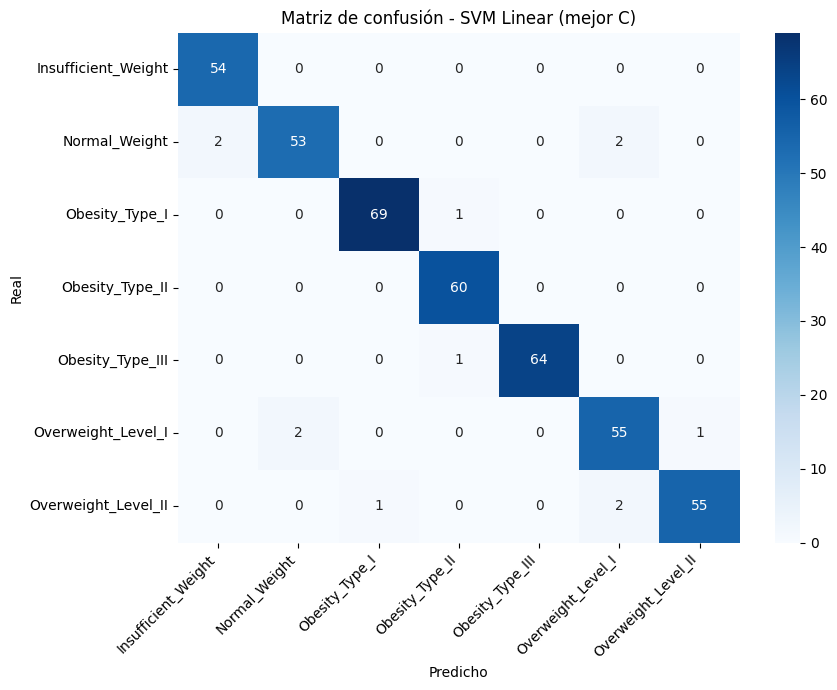

In [18]:
best_svm_name = part1_summary_df.iloc[0]['modelo']
best_svm_model, y_pred_best_svm, _ = part1_fitted[best_svm_name]

print('Mejor SVM:', best_svm_name)
print(classification_report(y_test, y_pred_best_svm, target_names=class_names))

save_confusion(
    y_test,
    y_pred_best_svm,
    class_names,
    'confusion_matrix_svm.png',
    f'Matriz de confusión - {best_svm_name}'
)


## 4. Parte 2: Árboles de Decisión

In [19]:
# 2.1 Árbol sin restricciones (baseline)
tree_full = DecisionTreeClassifier(random_state=RANDOM_STATE)

cv_full = cross_val_score(tree_full, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1)
t0 = time.perf_counter()
tree_full.fit(X_train, y_train)
baseline_tree_time = time.perf_counter() - t0

y_pred_tree_full = tree_full.predict(X_test)
m_tree_full = weighted_metrics(y_test, y_pred_tree_full)

tree_baseline_df = pd.DataFrame([{
    'configuracion': 'Sin restricciones',
    'train_accuracy': tree_full.score(X_train, y_train),
    'cv_accuracy_mean': cv_full.mean(),
    'cv_accuracy_std': cv_full.std(),
    'test_accuracy': tree_full.score(X_test, y_test),
    'f1_w': m_tree_full['f1_w'],
    'depth': tree_full.get_depth(),
    'n_leaves': tree_full.get_n_leaves(),
    'fit_time_s': baseline_tree_time,
}])

save_table(tree_baseline_df, '20_tree_baseline')
tree_baseline_df

,configuracion,train_accuracy,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,depth,n_leaves,fit_time_s
0,Sin restricciones,1.0,0.924036,0.011039,0.92891,0.929719,12,101,0.010189


In [20]:
# 2.2 Efecto de max_depth
depths = [1, 2, 3, 5, 7, 10, 15, None]
rows = []
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    cv = cross_val_score(tree, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    rows.append({
        'max_depth': str(depth),
        'train_accuracy': tree.score(X_train, y_train),
        'cv_accuracy_mean': cv.mean(),
        'cv_accuracy_std': cv.std(),
        'test_accuracy': tree.score(X_test, y_test),
        'f1_w': f1_score(y_test, y_pred, average='weighted'),
        'depth_real': tree.get_depth(),
        'n_leaves': tree.get_n_leaves(),
    })

tree_depth_df = pd.DataFrame(rows).sort_values('cv_accuracy_mean', ascending=False).reset_index(drop=True)
save_table(tree_depth_df, '21_tree_depth_sweep')
tree_depth_df

,max_depth,train_accuracy,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,depth_real,n_leaves
0,10,0.998813,0.925223,0.017444,0.928910,0.929719,10,98
1,None,1.000000,0.924036,0.011039,0.928910,0.929719,12,101
2,15,1.000000,0.922849,0.012866,0.928910,0.929719,12,101
3,7,0.945401,0.885460,0.025842,0.900474,0.900665,7,57
4,5,0.852819,0.823145,0.015430,0.819905,0.818479,5,25
5,3,0.643323,0.629080,0.006224,0.656398,0.644740,3,8
6,2,0.554303,0.553116,0.005504,0.545024,0.428680,2,4
7,1,0.290801,0.290801,0.002654,0.291469,0.142942,1,2


In [21]:
# 2.3 Criterios de división
criteria = ['gini', 'entropy', 'log_loss']
rows = []
for c in criteria:
    tree = DecisionTreeClassifier(criterion=c, random_state=RANDOM_STATE)
    cv = cross_val_score(tree, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1)
    tree.fit(X_train, y_train)
    rows.append({
        'criterion': c,
        'cv_accuracy_mean': cv.mean(),
        'cv_accuracy_std': cv.std(),
        'test_accuracy': tree.score(X_test, y_test),
        'n_leaves': tree.get_n_leaves(),
    })

tree_criteria_df = pd.DataFrame(rows).sort_values('cv_accuracy_mean', ascending=False).reset_index(drop=True)
save_table(tree_criteria_df, '22_tree_criteria')
tree_criteria_df

,criterion,cv_accuracy_mean,cv_accuracy_std,test_accuracy,n_leaves
0,entropy,0.941840,0.011508,0.959716,79
1,log_loss,0.941840,0.011508,0.959716,79
2,gini,0.924036,0.011039,0.928910,101


In [22]:
# 2.4 Poda previa: grid search
param_grid_tree = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 50],
}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid_tree,
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=-1,
)
grid_tree.fit(X_train, y_train)

print('Best tree params:', grid_tree.best_params_)
print('Best tree CV:', round(grid_tree.best_score_, 4))
print('Best tree test:', round(grid_tree.best_estimator_.score(X_test, y_test), 4))

tree_grid_df = pd.DataFrame(grid_tree.cv_results_)
cols = [
    'param_max_depth', 'param_min_samples_split',
    'param_min_samples_leaf', 'param_max_leaf_nodes',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]
tree_grid_compact = tree_grid_df[cols].sort_values('rank_test_score').reset_index(drop=True)

tree_grid_compact = tree_grid_compact.rename(columns={
    'param_max_depth': 'max_depth',
    'param_min_samples_split': 'min_samples_split',
    'param_min_samples_leaf': 'min_samples_leaf',
    'param_max_leaf_nodes': 'max_leaf_nodes',
    'mean_test_score': 'cv_accuracy_mean',
    'std_test_score': 'cv_accuracy_std',
})

save_table(tree_grid_compact, '23_tree_prepruning_grid_full')
save_table(tree_grid_compact.head(12), '24_tree_prepruning_grid_top12')
tree_grid_compact.head(12)

Best tree params: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best tree CV: 0.9288
Best tree test: 0.9218


,max_depth,min_samples_split,min_samples_leaf,max_leaf_nodes,cv_accuracy_mean,cv_accuracy_std,rank_test_score
0,None,2,2,None,0.928783,0.012589,1
1,None,5,1,None,0.927596,0.013867,2
2,None,5,2,None,0.927003,0.017465,3
3,10,2,2,None,0.925223,0.015969,4
4,10,2,1,None,0.925223,0.017444,5
5,10,5,1,None,0.925223,0.012364,5
6,10,5,2,None,0.924036,0.019647,7
7,None,2,1,None,0.924036,0.011039,7
8,None,2,2,50,0.922849,0.017098,9
9,10,2,2,50,0.922255,0.017343,10


In [23]:
# 2.5 Poda posterior: ccp_alpha
path = DecisionTreeClassifier(random_state=RANDOM_STATE).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = np.unique(path.ccp_alphas[:-1])

rows = []
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha=float(alpha), random_state=RANDOM_STATE)
    cv = cross_val_score(tree, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    rows.append({
        'ccp_alpha': float(alpha),
        'cv_accuracy_mean': cv.mean(),
        'cv_accuracy_std': cv.std(),
        'test_accuracy': tree.score(X_test, y_test),
        'f1_w': f1_score(y_test, y_pred, average='weighted'),
        'depth': tree.get_depth(),
        'n_leaves': tree.get_n_leaves(),
    })

tree_ccp_full_df = pd.DataFrame(rows).sort_values('ccp_alpha').reset_index(drop=True)

best_idx = int(tree_ccp_full_df['cv_accuracy_mean'].idxmax())
rep_idx = sorted(set([0, len(tree_ccp_full_df)//4, len(tree_ccp_full_df)//2, (3*len(tree_ccp_full_df))//4, len(tree_ccp_full_df)-1, best_idx]))
tree_ccp_rep_df = tree_ccp_full_df.loc[rep_idx].sort_values('ccp_alpha').reset_index(drop=True)

save_table(tree_ccp_full_df, '25_tree_ccp_full')
save_table(tree_ccp_rep_df, '26_tree_ccp_representative')
tree_ccp_rep_df

,ccp_alpha,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,depth,n_leaves
0,0.000000,0.924036,0.011039,0.928910,0.929719,12,101
1,0.000989,0.928190,0.011477,0.926540,0.927438,10,70
2,0.001107,0.925223,0.012784,0.926540,0.927438,10,67
3,0.001891,0.922255,0.021838,0.931280,0.931272,9,43
4,0.004780,0.895549,0.026234,0.919431,0.918765,8,25
5,0.091220,0.502671,0.064100,0.431280,0.321457,2,3


In [24]:
# 2.6 Importancia de características (best_tree de poda previa)
best_tree_pre = grid_tree.best_estimator_
importances = best_tree_pre.feature_importances_

feat_imp_tree_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance_gini': importances,
}).sort_values('importance_gini', ascending=False).reset_index(drop=True)
feat_imp_tree_df.insert(0, 'rank', np.arange(1, len(feat_imp_tree_df) + 1))

save_table(feat_imp_tree_df, '27_tree_feature_importance')
feat_imp_tree_df.head(15)

,rank,feature,importance_gini
0,1,Weight,0.506558
1,2,Height,0.246968
2,3,Gender,0.160277
3,4,Age,0.024752
4,5,FAVC,0.023797
5,6,CH2O,0.010139
6,7,CAEC_Sometimes,0.007591
7,8,TUE,0.004725
8,9,NCP,0.003756
9,10,CAEC_Frequently,0.002327


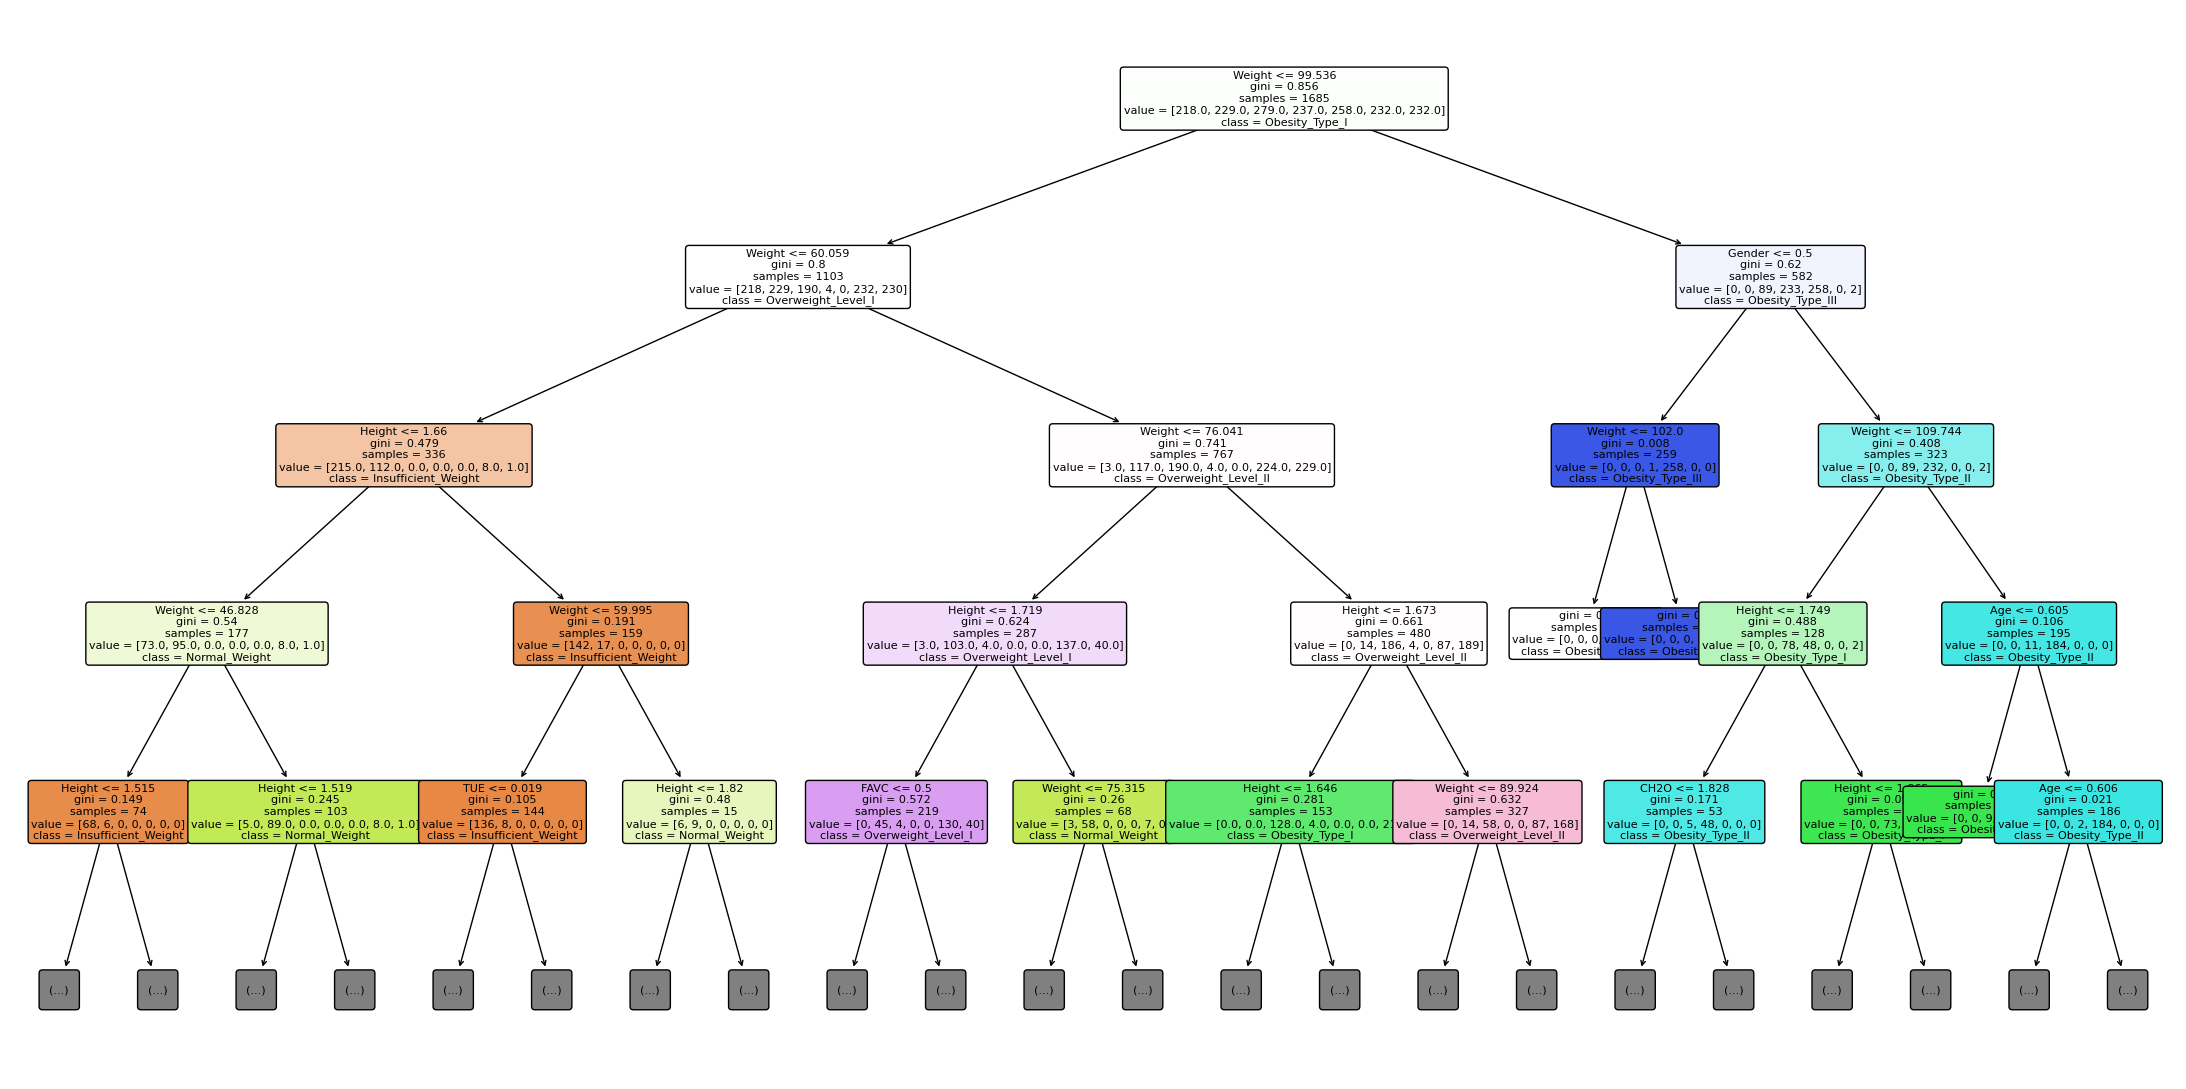

|--- Weight <= 99.54
|   |--- Weight <= 60.06
|   |   |--- Height <= 1.66
|   |   |   |--- Weight <= 46.83
|   |   |   |   |--- Height <= 1.51
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Height >  1.51
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- Weight >  46.83
|   |   |   |   |--- Height <= 1.52
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |--- Height >  1.52
|   |   |   |   |   |--- truncated branch of depth 4
|   |   |--- Height >  1.66
|   |   |   |--- Weight <= 60.00
|   |   |   |   |--- TUE <= 0.02
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- TUE >  0.02
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- Weight >  60.00
|   |   |   |   |--- Height <= 1.82
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Height >  1.82
|   |   |   |   |   |--- class: 0
|   |--- Weight >  60.06
|   |   |--- Weight <= 76.04
|   |   |   |--- Height <= 1.72
|   |   |   |   |--- FAVC <= 0.

In [25]:
# 2.7 Visualización del árbol
plt.figure(figsize=(22, 11))
plot_tree(
    best_tree_pre,
    feature_names=X_train.columns,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=4,
)
plt.tight_layout()
plt.savefig(IMAGES_DIR / 'decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

tree_text = export_text(best_tree_pre, feature_names=list(X_train.columns), max_depth=4)
(TABLES_DIR / 'decision_tree_text.txt').write_text(tree_text, encoding='utf-8')
print(tree_text[:3500])

In [26]:
# 2.8 Evaluación final Parte 2
# Mejor poda previa
res_pre, fitted_pre, y_pred_pre = evaluate_model(grid_tree.best_estimator_, X_train, y_train, X_test, y_test)

# Mejor poda posterior
best_alpha = float(tree_ccp_full_df.loc[tree_ccp_full_df['cv_accuracy_mean'].idxmax(), 'ccp_alpha'])
best_tree_post_model = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=RANDOM_STATE)
res_post, fitted_post, y_pred_post = evaluate_model(best_tree_post_model, X_train, y_train, X_test, y_test)

# Baseline ya entrenado
part2_summary_df = pd.DataFrame([
    {
        'modelo': 'Sin restricciones',
        'cv_accuracy_mean': float(tree_baseline_df.iloc[0]['cv_accuracy_mean']),
        'cv_accuracy_std': float(tree_baseline_df.iloc[0]['cv_accuracy_std']),
        'test_accuracy': float(tree_baseline_df.iloc[0]['test_accuracy']),
        'f1_w': float(tree_baseline_df.iloc[0]['f1_w']),
        'depth': int(tree_baseline_df.iloc[0]['depth']),
        'n_leaves': int(tree_baseline_df.iloc[0]['n_leaves']),
    },
    {
        'modelo': 'Mejor poda previa',
        'cv_accuracy_mean': res_pre['cv_accuracy_mean'],
        'cv_accuracy_std': res_pre['cv_accuracy_std'],
        'test_accuracy': res_pre['test_accuracy'],
        'f1_w': res_pre['f1_w'],
        'depth': fitted_pre.get_depth(),
        'n_leaves': fitted_pre.get_n_leaves(),
    },
    {
        'modelo': 'Mejor poda posterior',
        'cv_accuracy_mean': res_post['cv_accuracy_mean'],
        'cv_accuracy_std': res_post['cv_accuracy_std'],
        'test_accuracy': res_post['test_accuracy'],
        'f1_w': res_post['f1_w'],
        'depth': fitted_post.get_depth(),
        'n_leaves': fitted_post.get_n_leaves(),
    },
]).sort_values('test_accuracy', ascending=False).reset_index(drop=True)

save_table(part2_summary_df, '28_tree_part2_summary')
part2_summary_df

,modelo,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,depth,n_leaves
0,Sin restricciones,0.924036,0.011039,0.928910,0.929719,12,101
1,Mejor poda posterior,0.928190,0.011477,0.926540,0.927438,10,70
2,Mejor poda previa,0.928783,0.012589,0.921801,0.922354,11,90


Mejor modelo Parte 2: Mejor poda posterior


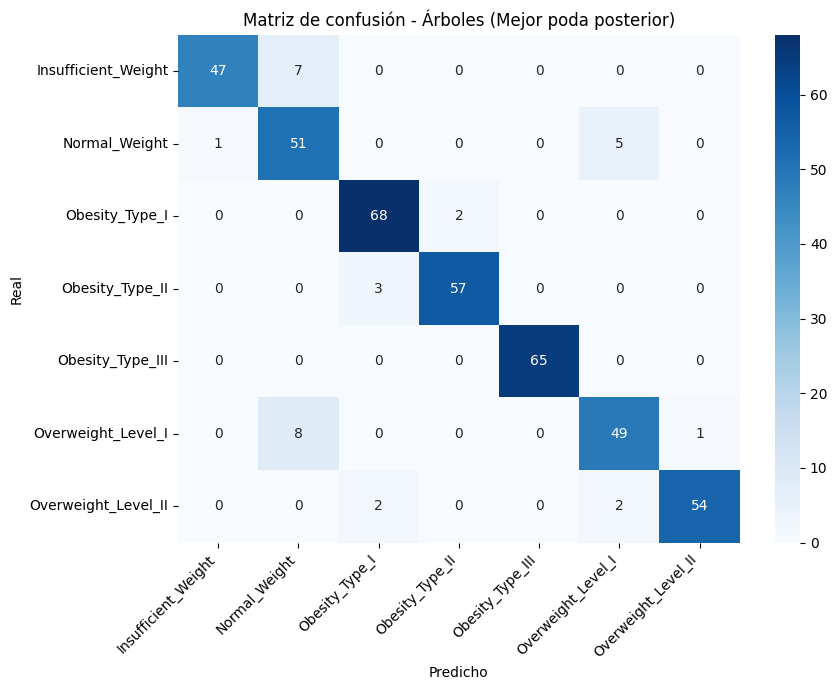

In [27]:
# Matriz de confusión mejor modelo Parte 2
if res_pre['test_accuracy'] >= res_post['test_accuracy']:
    part2_best_name = 'Mejor poda previa'
    part2_best_model = fitted_pre
    part2_best_pred = y_pred_pre
else:
    part2_best_name = 'Mejor poda posterior'
    part2_best_model = fitted_post
    part2_best_pred = y_pred_post

print('Mejor modelo Parte 2:', part2_best_name)
save_confusion(
    y_test,
    part2_best_pred,
    class_names,
    'confusion_matrix_tree.png',
    f'Matriz de confusión - Árboles ({part2_best_name})',
)


## 5. Parte 3: Random Forest

In [28]:
# 3.1 RF por defecto
rf_default = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, oob_score=True)

cv_rf_default = cross_val_score(rf_default, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1)
t0 = time.perf_counter()
rf_default.fit(X_train, y_train)
rf_default_time = time.perf_counter() - t0

y_pred_rf_default = rf_default.predict(X_test)
m_rf_default = weighted_metrics(y_test, y_pred_rf_default)

rf_default_df = pd.DataFrame([{
    'configuracion': 'RF default (n=100)',
    'cv_accuracy_mean': cv_rf_default.mean(),
    'cv_accuracy_std': cv_rf_default.std(),
    'oob_score': rf_default.oob_score_,
    'test_accuracy': rf_default.score(X_test, y_test),
    'f1_w': m_rf_default['f1_w'],
    'fit_time_s': rf_default_time,
}])

save_table(rf_default_df, '30_rf_default')
rf_default_df

,configuracion,cv_accuracy_mean,cv_accuracy_std,oob_score,test_accuracy,f1_w,fit_time_s
0,RF default (n=100),0.938872,0.018917,0.940653,0.947867,0.949005,0.478439


In [29]:
# 3.2 Efecto n_estimators
rows = []
for n in [10, 25, 50, 100, 200, 500]:
    rf = RandomForestClassifier(n_estimators=n, random_state=RANDOM_STATE, n_jobs=-1, oob_score=True)
    t0 = time.perf_counter()
    rf.fit(X_train, y_train)
    t_fit = time.perf_counter() - t0

    rows.append({
        'n_estimators': n,
        'oob_score': rf.oob_score_,
        'test_accuracy': rf.score(X_test, y_test),
        'fit_time_s': t_fit,
    })

rf_estimators_df = pd.DataFrame(rows).sort_values('n_estimators').reset_index(drop=True)
save_table(rf_estimators_df, '31_rf_estimators_sweep')
rf_estimators_df

,n_estimators,oob_score,test_accuracy,fit_time_s
0,10,0.842730,0.907583,0.063757
1,25,0.908605,0.936019,0.100570
2,50,0.927596,0.947867,0.165407
3,100,0.940653,0.947867,0.205642
4,200,0.944214,0.947867,0.389056
5,500,0.945401,0.952607,0.921432


In [30]:
# 3.3 Efecto max_features
rows = []
for mf in ['sqrt', 'log2', 0.5, None]:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_features=mf,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        oob_score=True,
    )
    rf.fit(X_train, y_train)
    rows.append({
        'max_features': str(mf),
        'oob_score': rf.oob_score_,
        'test_accuracy': rf.score(X_test, y_test),
    })

rf_max_features_df = pd.DataFrame(rows).sort_values('test_accuracy', ascending=False).reset_index(drop=True)
save_table(rf_max_features_df, '32_rf_max_features_sweep')
rf_max_features_df

,max_features,oob_score,test_accuracy
0,0.5,0.959050,0.954976
1,None,0.954303,0.952607
2,sqrt,0.940653,0.947867
3,log2,0.940653,0.947867


In [31]:
# 3.4 Grid Search RF
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 5],
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, oob_score=True),
    param_grid_rf,
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=-1,
)
grid_rf.fit(X_train, y_train)

print('Best RF params:', grid_rf.best_params_)
print('Best RF CV:', round(grid_rf.best_score_, 4))
print('Best RF test:', round(grid_rf.best_estimator_.score(X_test, y_test), 4))

rf_grid_df = pd.DataFrame(grid_rf.cv_results_)
rf_cols = ['param_n_estimators', 'param_max_features', 'param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score', 'rank_test_score']
rf_grid_compact = rf_grid_df[rf_cols].sort_values('rank_test_score').reset_index(drop=True)
rf_grid_compact = rf_grid_compact.rename(columns={
    'param_n_estimators': 'n_estimators',
    'param_max_features': 'max_features',
    'param_max_depth': 'max_depth',
    'param_min_samples_leaf': 'min_samples_leaf',
    'mean_test_score': 'cv_accuracy_mean',
    'std_test_score': 'cv_accuracy_std',
})

save_table(rf_grid_compact, '33_rf_grid_full')
save_table(rf_grid_compact.head(12), '34_rf_grid_top12')
rf_grid_compact.head(12)

Best RF params: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Best RF CV: 0.9519
Best RF test: 0.955


,n_estimators,max_features,max_depth,min_samples_leaf,cv_accuracy_mean,cv_accuracy_std,rank_test_score
0,200,None,None,1,0.951929,0.016828,1
1,200,None,20,1,0.951929,0.016828,1
2,100,None,20,1,0.950742,0.016953,3
3,100,None,None,1,0.950742,0.016953,3
4,200,None,10,1,0.949555,0.016786,5
5,200,None,None,2,0.948368,0.018157,6
6,200,None,20,2,0.948368,0.018157,6
7,100,None,10,1,0.947774,0.015769,8
8,100,None,None,2,0.947181,0.019267,9
9,100,None,20,2,0.947181,0.019267,9


In [32]:
# 3.5 Importancia de características (Gini + Permutation)
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train, y_train)

importances_gini = best_rf.feature_importances_
perm = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

rf_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'gini_importance': importances_gini,
    'perm_importance_mean': perm.importances_mean,
    'perm_importance_std': perm.importances_std,
}).sort_values('gini_importance', ascending=False).reset_index(drop=True)
rf_importance_df.insert(0, 'rank', np.arange(1, len(rf_importance_df) + 1))

save_table(rf_importance_df, '35_rf_feature_importance')
rf_importance_df.head(15)

,rank,feature,gini_importance,perm_importance_mean,perm_importance_std
0,1,Weight,0.458525,0.738389,0.018725
1,2,Height,0.246338,0.311611,0.015403
2,3,Gender,0.158342,0.172038,0.013866
3,4,Age,0.038769,0.058057,0.007587
4,5,FAVC,0.023532,0.005687,0.002172
5,6,FAF,0.012838,-0.002133,0.002691
6,7,FCVC,0.009884,-0.000474,0.002552
7,8,CH2O,0.008880,0.002844,0.002763
8,9,TUE,0.008615,0.002133,0.002893
9,10,NCP,0.008572,0.004502,0.002691


In [33]:
# 3.6 Extra Trees
et = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
res_et, fitted_et, y_pred_et = evaluate_model(et, X_train, y_train, X_test, y_test)

extra_trees_df = pd.DataFrame([{
    'modelo': 'Extra Trees',
    'cv_accuracy_mean': res_et['cv_accuracy_mean'],
    'cv_accuracy_std': res_et['cv_accuracy_std'],
    'test_accuracy': res_et['test_accuracy'],
    'f1_w': res_et['f1_w'],
    'fit_time_s': res_et['fit_time_s'],
}])

save_table(extra_trees_df, '36_extra_trees')
extra_trees_df

,modelo,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,fit_time_s
0,Extra Trees,0.91632,0.020507,0.92654,0.927715,0.1174


In [34]:
# 3.7 Evaluación final Parte 3
res_rf_best, fitted_rf_best, y_pred_rf_best = evaluate_model(grid_rf.best_estimator_, X_train, y_train, X_test, y_test)

part3_summary_df = pd.DataFrame([
    {
        'modelo': 'Decision Tree (baseline)',
        'cv_accuracy_mean': float(tree_baseline_df.iloc[0]['cv_accuracy_mean']),
        'cv_accuracy_std': float(tree_baseline_df.iloc[0]['cv_accuracy_std']),
        'test_accuracy': float(tree_baseline_df.iloc[0]['test_accuracy']),
        'f1_w': float(tree_baseline_df.iloc[0]['f1_w']),
        'oob_score': np.nan,
        'fit_time_s': float(tree_baseline_df.iloc[0]['fit_time_s']),
    },
    {
        'modelo': 'Random Forest default',
        'cv_accuracy_mean': float(rf_default_df.iloc[0]['cv_accuracy_mean']),
        'cv_accuracy_std': float(rf_default_df.iloc[0]['cv_accuracy_std']),
        'test_accuracy': float(rf_default_df.iloc[0]['test_accuracy']),
        'f1_w': float(rf_default_df.iloc[0]['f1_w']),
        'oob_score': float(rf_default_df.iloc[0]['oob_score']),
        'fit_time_s': float(rf_default_df.iloc[0]['fit_time_s']),
    },
    {
        'modelo': 'Random Forest mejor config',
        'cv_accuracy_mean': res_rf_best['cv_accuracy_mean'],
        'cv_accuracy_std': res_rf_best['cv_accuracy_std'],
        'test_accuracy': res_rf_best['test_accuracy'],
        'f1_w': res_rf_best['f1_w'],
        'oob_score': getattr(fitted_rf_best, 'oob_score_', np.nan),
        'fit_time_s': res_rf_best['fit_time_s'],
    },
    {
        'modelo': 'Extra Trees',
        'cv_accuracy_mean': res_et['cv_accuracy_mean'],
        'cv_accuracy_std': res_et['cv_accuracy_std'],
        'test_accuracy': res_et['test_accuracy'],
        'f1_w': res_et['f1_w'],
        'oob_score': np.nan,
        'fit_time_s': res_et['fit_time_s'],
    },
]).sort_values('test_accuracy', ascending=False).reset_index(drop=True)

save_table(part3_summary_df, '37_rf_part3_summary')
part3_summary_df

,modelo,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,oob_score,fit_time_s
0,Random Forest mejor config,0.951929,0.016828,0.954976,0.955283,0.957270,0.413982
1,Random Forest default,0.938872,0.018917,0.947867,0.949005,0.940653,0.478439
2,Decision Tree (baseline),0.924036,0.011039,0.928910,0.929719,NaN,0.010189
3,Extra Trees,0.916320,0.020507,0.926540,0.927715,NaN,0.117400


Mejor modelo Parte 3: RF best


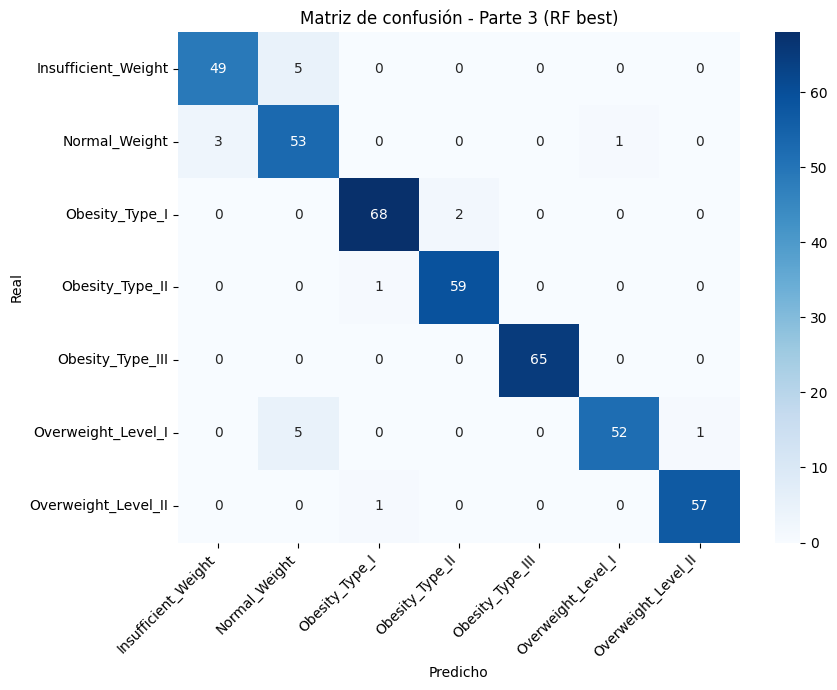

In [35]:
# Matriz de confusión mejor modelo Parte 3
part3_candidates = {
    'RF default': (rf_default, y_pred_rf_default),
    'RF best': (fitted_rf_best, y_pred_rf_best),
    'Extra Trees': (fitted_et, y_pred_et),
}

scores = {k: accuracy_score(y_test, v[1]) for k, v in part3_candidates.items()}
part3_best_name = max(scores, key=scores.get)
part3_best_model, part3_best_pred = part3_candidates[part3_best_name]

print('Mejor modelo Parte 3:', part3_best_name)
save_confusion(
    y_test,
    part3_best_pred,
    class_names,
    'confusion_matrix_rf.png',
    f'Matriz de confusión - Parte 3 ({part3_best_name})',
)


## 6. Parte 4: Gradient Boosting

In [36]:
# 4.1 Gradient Boosting por defecto
gb_default = GradientBoostingClassifier(random_state=RANDOM_STATE)
res_gb_default, fitted_gb_default, y_pred_gb_default = evaluate_model(gb_default, X_train, y_train, X_test, y_test)

gb_default_df = pd.DataFrame([{
    'modelo': 'Gradient Boosting default',
    'cv_accuracy_mean': res_gb_default['cv_accuracy_mean'],
    'cv_accuracy_std': res_gb_default['cv_accuracy_std'],
    'test_accuracy': res_gb_default['test_accuracy'],
    'f1_w': res_gb_default['f1_w'],
    'fit_time_s': res_gb_default['fit_time_s'],
}])

save_table(gb_default_df, '40_gb_default')
gb_default_df

,modelo,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,fit_time_s
0,Gradient Boosting default,0.956083,0.018137,0.966825,0.967405,2.688829


In [37]:
# 4.2 Efecto n_estimators y learning_rate
configs = [
    (50, 0.1), (100, 0.1), (200, 0.1),
    (50, 0.5), (100, 0.05), (200, 0.01),
]

rows = []
for n_est, lr in configs:
    gb = GradientBoostingClassifier(n_estimators=n_est, learning_rate=lr, random_state=RANDOM_STATE)
    cv = cross_val_score(gb, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1)
    gb.fit(X_train, y_train)
    rows.append({
        'n_estimators': n_est,
        'learning_rate': lr,
        'cv_accuracy_mean': cv.mean(),
        'cv_accuracy_std': cv.std(),
        'test_accuracy': gb.score(X_test, y_test),
    })

gb_lr_df = pd.DataFrame(rows).sort_values('cv_accuracy_mean', ascending=False).reset_index(drop=True)
save_table(gb_lr_df, '41_gb_estimators_lr_sweep')
gb_lr_df

,n_estimators,learning_rate,cv_accuracy_mean,cv_accuracy_std,test_accuracy
0,200,0.10,0.960831,0.014219,0.971564
1,50,0.50,0.956677,0.012104,0.954976
2,100,0.10,0.956083,0.018137,0.966825
3,50,0.10,0.945994,0.018426,0.943128
4,100,0.05,0.943027,0.020848,0.945498
5,200,0.01,0.906825,0.018730,0.900474


In [38]:
# 4.3 Efecto max_depth
rows = []
for depth in [1, 2, 3, 5]:
    gb = GradientBoostingClassifier(max_depth=depth, n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE)
    cv = cross_val_score(gb, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1)
    gb.fit(X_train, y_train)
    rows.append({
        'max_depth': depth,
        'train_accuracy': gb.score(X_train, y_train),
        'cv_accuracy_mean': cv.mean(),
        'cv_accuracy_std': cv.std(),
        'test_accuracy': gb.score(X_test, y_test),
    })

gb_depth_df = pd.DataFrame(rows).sort_values('cv_accuracy_mean', ascending=False).reset_index(drop=True)
save_table(gb_depth_df, '42_gb_depth_sweep')
gb_depth_df

,max_depth,train_accuracy,cv_accuracy_mean,cv_accuracy_std,test_accuracy
0,5,1.000000,0.956677,0.014366,0.959716
1,3,1.000000,0.956083,0.018137,0.966825
2,2,0.990504,0.938872,0.010382,0.940758
3,1,0.878932,0.843323,0.008266,0.841232


In [39]:
# 4.4 Grid Search GB
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [1, 2, 3],
    'subsample': [0.8, 1.0],
}

grid_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid_gb,
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=-1,
)
grid_gb.fit(X_train, y_train)

print('Best GB params:', grid_gb.best_params_)
print('Best GB CV:', round(grid_gb.best_score_, 4))
print('Best GB test:', round(grid_gb.best_estimator_.score(X_test, y_test), 4))

gb_grid_df = pd.DataFrame(grid_gb.cv_results_)
gb_cols = ['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_subsample', 'mean_test_score', 'std_test_score', 'rank_test_score']
gb_grid_compact = gb_grid_df[gb_cols].sort_values('rank_test_score').reset_index(drop=True)
gb_grid_compact = gb_grid_compact.rename(columns={
    'param_n_estimators': 'n_estimators',
    'param_learning_rate': 'learning_rate',
    'param_max_depth': 'max_depth',
    'param_subsample': 'subsample',
    'mean_test_score': 'cv_accuracy_mean',
    'std_test_score': 'cv_accuracy_std',
})

save_table(gb_grid_compact, '43_gb_grid_full')
save_table(gb_grid_compact.head(12), '44_gb_grid_top12')
gb_grid_compact.head(12)

Best GB params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best GB CV: 0.9608
Best GB test: 0.9716


,n_estimators,learning_rate,max_depth,subsample,cv_accuracy_mean,cv_accuracy_std,rank_test_score
0,200,0.1,3,1.0,0.960831,0.014219,1
1,200,0.5,3,1.0,0.958457,0.010106,2
2,200,0.1,3,0.8,0.958457,0.011103,2
3,200,0.05,3,0.8,0.958457,0.013002,2
4,200,0.05,3,1.0,0.957864,0.014825,5
5,100,0.5,3,0.8,0.957270,0.011810,6
6,100,0.5,3,1.0,0.957270,0.008922,6
7,200,0.5,3,0.8,0.956677,0.013217,8
8,100,0.1,3,1.0,0.956083,0.018137,9
9,100,0.1,3,0.8,0.954896,0.008682,10


In [40]:
# 4.5 AdaBoost con stump
ada_configs = [(50, 1.0), (100, 1.0), (100, 0.5), (200, 0.1)]
rows = []
ada_fitted = {}

for n_est, lr in ada_configs:
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE),
        n_estimators=n_est,
        learning_rate=lr,
        random_state=RANDOM_STATE,
    )
    res, fitted, y_pred = evaluate_model(ada, X_train, y_train, X_test, y_test)
    name = f'AdaBoost (n={n_est}, lr={lr})'
    rows.append({
        'configuracion': name,
        'n_estimators': n_est,
        'learning_rate': lr,
        'cv_accuracy_mean': res['cv_accuracy_mean'],
        'cv_accuracy_std': res['cv_accuracy_std'],
        'test_accuracy': res['test_accuracy'],
        'f1_w': res['f1_w'],
        'fit_time_s': res['fit_time_s'],
    })
    ada_fitted[name] = (fitted, y_pred, res)

ada_df = pd.DataFrame(rows).sort_values('cv_accuracy_mean', ascending=False).reset_index(drop=True)
save_table(ada_df, '45_adaboost_sweep')
ada_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R

,configuracion,n_estimators,learning_rate,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,fit_time_s
0,"AdaBoost (n=100, lr=0.5)",100,0.5,0.389911,0.025705,0.426540,0.323294,0.298934
1,"AdaBoost (n=50, lr=1.0)",50,1.0,0.344214,0.009931,0.348341,0.251932,0.147979
2,"AdaBoost (n=100, lr=1.0)",100,1.0,0.319288,0.034534,0.348341,0.251932,0.295942
3,"AdaBoost (n=200, lr=0.1)",200,0.1,0.284273,0.008266,0.284360,0.182460,0.593164


In [41]:
# 4.6 Evaluación final Parte 4
res_gb_best, fitted_gb_best, y_pred_gb_best = evaluate_model(grid_gb.best_estimator_, X_train, y_train, X_test, y_test)

best_ada_name = ada_df.iloc[0]['configuracion']
fitted_ada_best, y_pred_ada_best, res_ada_best = ada_fitted[best_ada_name]

part4_summary_df = pd.DataFrame([
    {
        'modelo': 'Random Forest (mejor config)',
        'cv_accuracy_mean': res_rf_best['cv_accuracy_mean'],
        'cv_accuracy_std': res_rf_best['cv_accuracy_std'],
        'test_accuracy': res_rf_best['test_accuracy'],
        'f1_w': res_rf_best['f1_w'],
        'fit_time_s': res_rf_best['fit_time_s'],
    },
    {
        'modelo': 'Gradient Boosting default',
        'cv_accuracy_mean': res_gb_default['cv_accuracy_mean'],
        'cv_accuracy_std': res_gb_default['cv_accuracy_std'],
        'test_accuracy': res_gb_default['test_accuracy'],
        'f1_w': res_gb_default['f1_w'],
        'fit_time_s': res_gb_default['fit_time_s'],
    },
    {
        'modelo': 'Gradient Boosting mejor config',
        'cv_accuracy_mean': res_gb_best['cv_accuracy_mean'],
        'cv_accuracy_std': res_gb_best['cv_accuracy_std'],
        'test_accuracy': res_gb_best['test_accuracy'],
        'f1_w': res_gb_best['f1_w'],
        'fit_time_s': res_gb_best['fit_time_s'],
    },
    {
        'modelo': 'AdaBoost (mejor config)',
        'cv_accuracy_mean': res_ada_best['cv_accuracy_mean'],
        'cv_accuracy_std': res_ada_best['cv_accuracy_std'],
        'test_accuracy': res_ada_best['test_accuracy'],
        'f1_w': res_ada_best['f1_w'],
        'fit_time_s': res_ada_best['fit_time_s'],
    },
]).sort_values('test_accuracy', ascending=False).reset_index(drop=True)

save_table(part4_summary_df, '46_boosting_part4_summary')
part4_summary_df

,modelo,cv_accuracy_mean,cv_accuracy_std,test_accuracy,f1_w,fit_time_s
0,Gradient Boosting mejor config,0.960831,0.014219,0.971564,0.971800,5.417529
1,Gradient Boosting default,0.956083,0.018137,0.966825,0.967405,2.688829
2,Random Forest (mejor config),0.951929,0.016828,0.954976,0.955283,0.413982
3,AdaBoost (mejor config),0.389911,0.025705,0.426540,0.323294,0.298934


Mejor modelo Parte 4: GB best


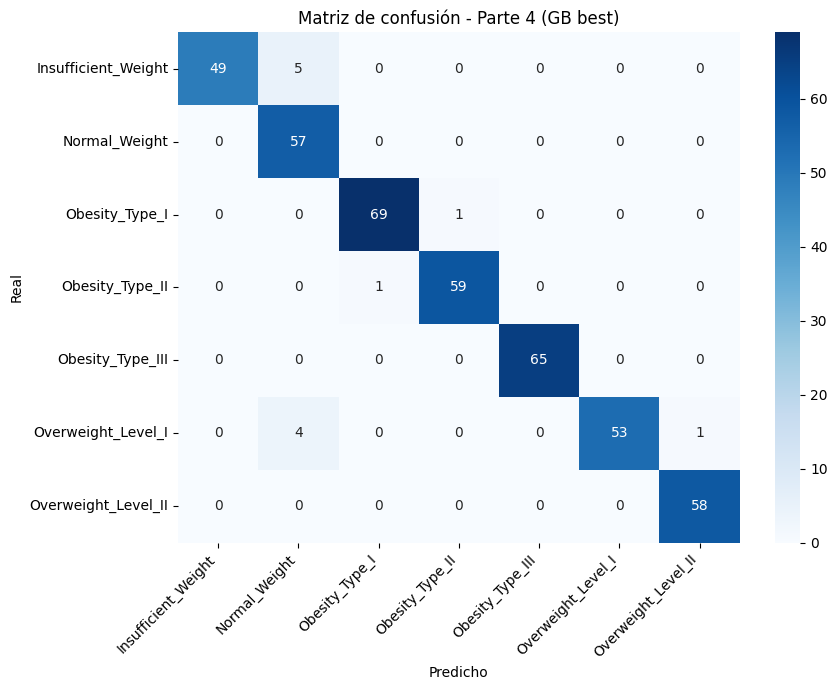

In [42]:
# Matriz de confusión mejor modelo Parte 4
part4_candidates = {
    'RF best': (fitted_rf_best, y_pred_rf_best),
    'GB default': (fitted_gb_default, y_pred_gb_default),
    'GB best': (fitted_gb_best, y_pred_gb_best),
    'AdaBoost best': (fitted_ada_best, y_pred_ada_best),
}

scores = {k: accuracy_score(y_test, v[1]) for k, v in part4_candidates.items()}
part4_best_name = max(scores, key=scores.get)
part4_best_model, part4_best_pred = part4_candidates[part4_best_name]

print('Mejor modelo Parte 4:', part4_best_name)
save_confusion(
    y_test,
    part4_best_pred,
    class_names,
    'confusion_matrix_boosting.png',
    f'Matriz de confusión - Parte 4 ({part4_best_name})',
)


## 7. Comparativa global final

In [43]:
global_models = {
    'SVM (mejor config)': grid_rbf.best_estimator_,
    'Decision Tree': part2_best_model,
    'Random Forest': grid_rf.best_estimator_,
    'Gradient Boosting': grid_gb.best_estimator_,
    'AdaBoost': fitted_ada_best,
}

rows = []
fitted_global = {}
for name, model in global_models.items():
    res, fitted, y_pred = evaluate_model(model, X_train, y_train, X_test, y_test)
    rows.append({
        'modelo': name,
        'cv_accuracy_mean': res['cv_accuracy_mean'],
        'cv_accuracy_std': res['cv_accuracy_std'],
        'test_accuracy': res['test_accuracy'],
        'precision_w': res['precision_w'],
        'recall_w': res['recall_w'],
        'f1_w': res['f1_w'],
        'fit_time_s': res['fit_time_s'],
    })
    fitted_global[name] = (fitted, y_pred, res)

global_summary_df = pd.DataFrame(rows).sort_values('test_accuracy', ascending=False).reset_index(drop=True)
save_table(global_summary_df, '50_global_comparison')
global_summary_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R

,modelo,cv_accuracy_mean,cv_accuracy_std,test_accuracy,precision_w,recall_w,f1_w,fit_time_s
0,Gradient Boosting,0.960831,0.014219,0.971564,0.974512,0.971564,0.971800,5.577681
1,Random Forest,0.951929,0.016828,0.954976,0.956814,0.954976,0.955283,0.441143
2,SVM (mejor config),0.940059,0.018234,0.943128,0.943953,0.943128,0.943202,0.065906
3,Decision Tree,0.928190,0.011477,0.926540,0.930776,0.926540,0.927438,0.010250
4,AdaBoost,0.389911,0.025705,0.426540,0.275877,0.426540,0.323294,0.313508


Mejor modelo global: Gradient Boosting
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.91      0.95        54
      Normal_Weight       0.86      1.00      0.93        57
     Obesity_Type_I       0.99      0.99      0.99        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       1.00      0.91      0.95        58
Overweight_Level_II       0.98      1.00      0.99        58

           accuracy                           0.97       422
          macro avg       0.97      0.97      0.97       422
       weighted avg       0.97      0.97      0.97       422



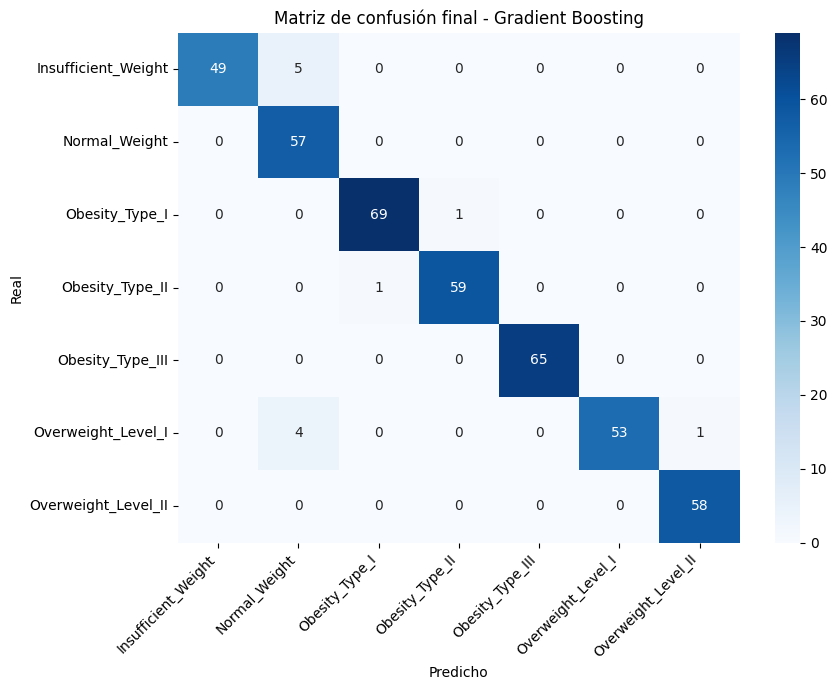

In [44]:
best_global_name = global_summary_df.iloc[0]['modelo']
best_global_model, y_pred_global, _ = fitted_global[best_global_name]

print('Mejor modelo global:', best_global_name)
print(classification_report(y_test, y_pred_global, target_names=class_names))

save_confusion(
    y_test,
    y_pred_global,
    class_names,
    'confusion_matrix_final.png',
    f'Matriz de confusión final - {best_global_name}',
)


## 8. Checklist automático de entregables
Verificación rápida de artefactos generados para la memoria (`images/` y `tables/`).

In [45]:
required_images = [
    'distribuciones_univariadas.png',
    'boxplots.png',
    'correlacion_matrix.png',
    'scatter_plots.png',
    'class_distribution.png',
    'pca_visualization.png',
    'confusion_matrix_svm.png',
    'decision_tree.png',
    'confusion_matrix_tree.png',
    'confusion_matrix_rf.png',
    'confusion_matrix_boosting.png',
    'confusion_matrix_final.png',
]

required_tables = [
    '00_preprocessing_checks.csv',
    '10_svm_kernels_default.csv',
    '12_svm_rbf_grid_representative.csv',
    '13_svm_poly_grid_full.csv',
    '16_svm_part1_summary.csv',
    '20_tree_baseline.csv',
    '21_tree_depth_sweep.csv',
    '23_tree_prepruning_grid_full.csv',
    '26_tree_ccp_representative.csv',
    '28_tree_part2_summary.csv',
    '30_rf_default.csv',
    '31_rf_estimators_sweep.csv',
    '32_rf_max_features_sweep.csv',
    '33_rf_grid_full.csv',
    '35_rf_feature_importance.csv',
    '37_rf_part3_summary.csv',
    '40_gb_default.csv',
    '41_gb_estimators_lr_sweep.csv',
    '42_gb_depth_sweep.csv',
    '43_gb_grid_full.csv',
    '45_adaboost_sweep.csv',
    '46_boosting_part4_summary.csv',
    '50_global_comparison.csv',
]

status_img = pd.DataFrame({'image': required_images})
status_img['exists'] = status_img['image'].apply(lambda x: (IMAGES_DIR / x).exists())

status_tab = pd.DataFrame({'table': required_tables})
status_tab['exists'] = status_tab['table'].apply(lambda x: (TABLES_DIR / x).exists())

print('Imágenes faltantes:', (~status_img['exists']).sum())
print('Tablas faltantes:', (~status_tab['exists']).sum())

display(status_img)
display(status_tab)

save_table(status_img, '99_artifacts_images_status')
save_table(status_tab, '99_artifacts_tables_status')

Imágenes faltantes: 0
Tablas faltantes: 0


,image,exists
0,distribuciones_univariadas.png,True
1,boxplots.png,True
2,correlacion_matrix.png,True
3,scatter_plots.png,True
4,class_distribution.png,True
5,pca_visualization.png,True
6,confusion_matrix_svm.png,True
7,decision_tree.png,True
8,confusion_matrix_tree.png,True
9,confusion_matrix_rf.png,True


,table,exists
0,00_preprocessing_checks.csv,True
1,10_svm_kernels_default.csv,True
2,12_svm_rbf_grid_representative.csv,True
3,13_svm_poly_grid_full.csv,True
4,16_svm_part1_summary.csv,True
5,20_tree_baseline.csv,True
6,21_tree_depth_sweep.csv,True
7,23_tree_prepruning_grid_full.csv,True
8,26_tree_ccp_representative.csv,True
9,28_tree_part2_summary.csv,True


,table,exists
0,00_preprocessing_checks.csv,True
1,10_svm_kernels_default.csv,True
2,12_svm_rbf_grid_representative.csv,True
3,13_svm_poly_grid_full.csv,True
4,16_svm_part1_summary.csv,True
5,20_tree_baseline.csv,True
6,21_tree_depth_sweep.csv,True
7,23_tree_prepruning_grid_full.csv,True
8,26_tree_ccp_representative.csv,True
9,28_tree_part2_summary.csv,True
